In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
annualization_factor=260
aspect_ratio=(12,8)

In [2]:
# Invoking the read_price_data function used in HW1
def read_price_data(filename, index_col=0, parse_dates=True):

    # Read the CSV file into a DataFrame
    print("Reading the CSV file into a DataFrame...")
    df = pd.read_csv(filename, index_col=index_col, parse_dates=parse_dates)

    # Print the DataFrame's info
    print("\n1. DataFrame Information:")
    df.info()

    # Check for any null values in the DataFrame
    print("\n2. Checking for null values in the DataFrame:")
    print(df.isnull().sum())

    # Print summary statistics of the DataFrame
    print("\n3. Summary statistics of the DataFrame:")
    print(df.describe())

    # Display the first few rows of the DataFrame
    print("\n4. Displaying the first and last few rows of the DataFrame:")
    print(df)

    return df

In [3]:
def print_pct_data(data_frame, format_spec="{:.4%}", na_rep="NaN", index_slice=None):
    if index_slice is not None:
        # Apply formatting to the specified subset
        return data_frame.style.format(format_spec, na_rep=na_rep, subset=pd.IndexSlice[index_slice])
    else:
        # Apply formatting to the entire DataFrame
        return data_frame.style.format(format_spec, na_rep=na_rep)

In [4]:
def calcPerformanceStatistics(cum_log_returns_final, annualization_factor=260, print_screen=True, percent_format_string="{:.2%}"):

    if not cum_log_returns_final.iloc[0].isna().all():                 #first row null or not
        nan_row = pd.DataFrame([[np.nan] * len(cum_log_returns_final.columns)], columns=cum_log_returns_final.columns)
        cum_log_returns_final = pd.concat([nan_row, cum_log_returns_final]).reset_index(drop=True)

    # If there's a NaN row that isn't the first row or incomplete, raise an error
    if cum_log_returns_final.isna().sum(axis=1).max() > 0 and not cum_log_returns_final.iloc[0].isna().all():
        raise ValueError("First row must be entirely NaN and there should not be NaN values elsewhere in the data")

    # Drop the NaN row for further calculations
    cum_log_returns_final = cum_log_returns_final.dropna()

    # Cumulative return (assuming log returns, using .cumsum())
    cum_returns = cum_log_returns_final.cumsum()

    # Annualized Return: Mean of returns * annualization factor
    annualized_return = cum_log_returns_final.mean() * annualization_factor

    # Annualized Volatility (Standard Deviation of returns * sqrt of annualization factor)
    annualized_volatility = cum_log_returns_final.std() * np.sqrt(annualization_factor)

    # Sharpe Ratio: Annualized Return / Annualized Volatility
    sharpe_ratio = annualized_return / annualized_volatility

    # Maximum Drawdown: Max cumulative return - Min cumulative return
    drawdown = cum_returns.fillna(0).cumsum() - cum_returns.fillna(0).cumsum().cummax()
    max_drawdown = drawdown.min()

    # Create underwater curve
    underwater_curve = cum_returns.fillna(0) - np.maximum.accumulate(cum_returns.fillna(0))

    # Creating a DataFrame to hold the performance statistics
    performance_stats = pd.DataFrame({
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    })

    if print_screen:
        print("Performance Statistics:")
        display(print_pct_data(performance_stats, format_spec=percent_format_string))

    return performance_stats

In [5]:
def movingAverageCrossover(df, fastWindow, slowWindow):
    instrument_name = df.columns[0]
    df=df[[instrument_name]]

    if df.shape[1] != 1:
        raise ValueError("Dataframe has >1 columns")

    instrument_name = df.columns[0]

    df['FastSMA'] = df[instrument_name].rolling(window=fastWindow).mean()
    df['SlowSMA'] = df[instrument_name].rolling(window=slowWindow).mean()

    df.dropna(inplace=True)

    df['Position-Flat'] = np.where(df['FastSMA'] > df['SlowSMA'], 1, 0)
    df['Position-Short'] = np.where(df['FastSMA'] > df['SlowSMA'], 1, -1)

    df[f'{instrument_name}-BMK-MA'] = np.log(df[instrument_name] / df[instrument_name].shift(1))


    df[f'{instrument_name}-MAFlat'] = df['Position-Flat'].shift(1) * df[f'{instrument_name}-BMK-MA']
    df[f'{instrument_name}-MAShort'] = df['Position-Short'].shift(1) * df[f'{instrument_name}-BMK-MA']

    return df

In [6]:
def bollingerBands(df, lookbackWindow, stdevBand):
  instrument_name = df.columns[0]
  df=df[[instrument_name]]
  if df.shape[1] != 1:
        raise ValueError("Dataframe has >1 columns")

  instrument_name = df.columns[0]
  df.loc[:,'Mean'] = df[instrument_name].rolling(lookbackWindow).mean()
  df.loc[:,'Stdev'] = df[instrument_name].rolling(lookbackWindow).std()

  df.dropna(inplace=True)

  df.loc[:,'Upper'] = df['Mean'] + stdevBand * df['Stdev']
  df.loc[:,'Lower'] = df['Mean'] - stdevBand * df['Stdev']

  # now we implement the Bollinger band based strategy

# initialize the first row based on the close price vis-a-vis the bands
# here, we're also initializng a new column called 'Position'
# using .loc as before
  date0 = df.index[0]
  if df.loc[date0,instrument_name] >= df.loc[date0, 'Upper']:
      df.loc[date0, 'Position-BB'] = -1
  elif df.loc[date0,instrument_name] <= df.loc[date0,'Lower']:
      df.loc[date0, 'Position-BB'] = 1
  else:
      df.loc[date0, 'Position-BB'] = 0

  # then loop over the entire data set
  for i in range(1, df.shape[0]):
      today=df.index[i]
      yesterday=df.index[i-1]
      if df.loc[today,instrument_name] >= df.loc[today,'Upper']: # if close is above upper
          df.loc[today,'Position-BB'] = -1 # then go short
      elif df.loc[today,instrument_name] <= df.loc[today,'Lower']: # if close is below lower
          df.loc[today,'Position-BB'] = 1 # then go long
      elif df.loc[yesterday,'Position-BB'] == -1 and df.loc[today,instrument_name] <= df.loc[today,'Mean']: # if prev day is short and we're now below the mean
          df.loc[today,'Position-BB']=0 # then flatten
      elif df.loc[yesterday,'Position-BB'] == 1 and df.loc[today, instrument_name] >= df.loc[today, 'Mean']: # conversely...
          df.loc[today,'Position-BB']=0 # then also flatten
      else: # otherwise just hold yesterday's position
          df.loc[today,'Position-BB']=df.loc[yesterday,'Position-BB']

  df[f'{instrument_name}--BMK--BB'] = np.log(df[instrument_name] / df[instrument_name].shift(1))
  df[f'{instrument_name}--BB'] = df['Position-BB'].shift(1) * df[f'{instrument_name}--BMK--BB']

  return df

In [7]:
def runMovingAverageAndBB(dataFrame, fastWindow, slowWindow, bbWindow, stdevBand):
    ma_result = movingAverageCrossover(dataFrame, fastWindow, slowWindow)

    bb_result = bollingerBands(dataFrame, bbWindow, stdevBand)

    df_final = ma_result.merge(bb_result, how='inner',left_index=True, right_index=True)

    return df_final

Q1 Uploading into Python the supplied data file which now contains close price data for all the same securities as in Part A, but from 12/31/1999 through 10/31/2022.

In [8]:
import pandas as pd

# Load the data from the CSV file
allprices_df = pd.read_csv('PricesProjectB.csv', index_col=0, parse_dates=True)

# Display the first few rows of the DataFrame to understand its structure
print(allprices_df.head())
print(allprices_df.tail())

                AAPL      AMZN        ATT     AUD     EUR  FBNDX          GE  \
1999-12-31  0.917969  3.806250  36.820244  0.6567  1.0062   6.89  396.794861   
2000-01-03  0.999442  4.468750  35.498489  0.6585  1.0243   6.85  384.615387   
2000-01-04  0.915179  4.096875  33.421452  0.6550  1.0296   6.87  369.230774   
2000-01-05  0.928571  3.487500  33.940708  0.6579  1.0321   6.84  368.589752   
2000-01-06  0.848214  3.278125  33.043808  0.6533  1.0328   6.86  373.517639   

              GOLD      INTC        LEHM  SILVER       SPY  
1999-12-31  288.00  41.15625  798.154631   5.380  146.8750  
2000-01-03  289.00  43.50000  793.868670   5.405  145.4375  
2000-01-04  282.25  41.46875  796.761677   5.325  139.7500  
2000-01-05  280.00  41.81250  793.118215   5.145  140.0000  
2000-01-06  281.10  39.37500  795.091984   5.120  137.7500  
                  AAPL        AMZN        ATT     AUD     EUR  FBNDX  \
2022-10-25  152.339996  120.599998  17.690001  0.6394  0.9966   6.88   
2022-10-2

Q2. copy+paste the 5 lines of code from your Project A notebook which specify your choice of parameters at the top of your Project B notebook so that we can once again copy+paste into our grading template.

In [9]:
maFast = 46
maSlow = 260
bbWindow = 20
bbStdevBand = 2
#myStrategies = ['AAPL-MAFlat', 'AMZN-MAFlat', 'EUR-MAShort', 'GE-MAShort','GOLD--BMK--BB', 'INTC--BB', 'LEHM--BMK--BB', 'SPY-MAFlat'] -- derived later in this question again

In [10]:
# Data preparation of each security

aapl = allprices_df[['AAPL']]
amzn = allprices_df[['AMZN']]
intc = allprices_df[['INTC']]
att = allprices_df[['ATT']]
ge = allprices_df[['GE']]
spy = allprices_df[['SPY']]
gold = allprices_df[['GOLD']]
silver = allprices_df[['SILVER']]
fbndx = allprices_df[['FBNDX']]
lehm = allprices_df[['LEHM']]
aud = allprices_df[['AUD']]
eur = allprices_df[['EUR']]


In [11]:
df_aapl = runMovingAverageAndBB(aapl, maFast, maSlow, bbWindow, bbStdevBand)

df_aapl_selected = df_aapl[['AAPL-BMK-MA', 'AAPL-MAFlat', 'AAPL-MAShort', 'AAPL--BB', 'AAPL--BMK--BB']]
stats_aapl=calcPerformanceStatistics(df_aapl_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")


stats_aapl

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
AAPL-BMK-MA,0.294560,0.366491,0.803732,-40.819702
AAPL-MAFlat,0.232064,0.292037,0.794640,-60.716179
AAPL-MAShort,0.169568,0.366795,0.462297,-147.789965
AAPL--BB,-0.123521,0.278080,-0.444192,-5987.937667
AAPL--BMK--BB,0.294560,0.366491,0.803732,-40.819702


In [12]:
df_amzn = runMovingAverageAndBB(amzn, maFast, maSlow, bbWindow, bbStdevBand)
df_amzn_selected = df_amzn[['AMZN-BMK-MA', 'AMZN-MAFlat', 'AMZN-MAShort', 'AMZN--BB', 'AMZN--BMK--BB']]
stats_amzn = calcPerformanceStatistics(df_amzn_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_amzn

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
AMZN-BMK-MA,0.228851,0.468676,0.488293,-115.915456
AMZN-MAFlat,0.192302,0.320925,0.599210,-0.046958
AMZN-MAShort,0.155752,0.468792,0.332241,-1.423759
AMZN--BB,0.057188,0.338486,0.168952,-0.827282
AMZN--BMK--BB,0.228851,0.468676,0.488293,-115.915456


In [13]:
# INTC
df_intc = runMovingAverageAndBB(intc, maFast, maSlow, bbWindow, bbStdevBand)
df_intc_selected = df_intc[['INTC-BMK-MA', 'INTC-MAFlat', 'INTC-MAShort', 'INTC--BB', 'INTC--BMK--BB']]
stats_intc = calcPerformanceStatistics(df_intc_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_intc


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
INTC-BMK-MA,-0.007659,0.360958,-0.021218,-1331.948092
INTC-MAFlat,-0.025008,0.226500,-0.110409,-1001.847742
INTC-MAShort,-0.042357,0.360949,-0.117349,-1875.016426
INTC--BB,0.090704,0.264635,0.342752,-0.370087
INTC--BMK--BB,-0.007659,0.360958,-0.021218,-1331.948092


In [14]:
# GE
df_ge = runMovingAverageAndBB(ge, maFast, maSlow, bbWindow, bbStdevBand)
df_ge_selected = df_ge[['GE-BMK-MA', 'GE-MAFlat', 'GE-MAShort', 'GE--BB', 'GE--BMK--BB']]
stats_ge = calcPerformanceStatistics(df_ge_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_ge


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
GE-BMK-MA,-0.072916,0.340145,-0.214367,-4167.449674
GE-MAFlat,-0.042024,0.180357,-0.233002,-755.084764
GE-MAShort,-0.011131,0.340174,-0.032723,-129.726479
GE--BB,-0.079831,0.268463,-0.297363,-4529.535182
GE--BMK--BB,-0.072916,0.340145,-0.214367,-4167.449674


In [15]:
# SPY
df_spy = runMovingAverageAndBB(spy, maFast, maSlow, bbWindow, bbStdevBand)
df_spy_selected = df_spy[['SPY-BMK-MA', 'SPY-MAFlat', 'SPY-MAShort', 'SPY--BB', 'SPY--BMK--BB']]
stats_spy = calcPerformanceStatistics(df_spy_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_spy


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
SPY-BMK-MA,0.051183,0.200017,0.255892,-367.408651
SPY-MAFlat,0.061454,0.131092,0.468788,0.000000
SPY-MAShort,0.071726,0.199993,0.358645,-0.436120
SPY--BB,0.032461,0.152559,0.212779,-176.489690
SPY--BMK--BB,0.051183,0.200017,0.255892,-367.408651


In [16]:
# GOLD
df_gold = runMovingAverageAndBB(gold, maFast, maSlow, bbWindow, bbStdevBand)
df_gold_selected = df_gold[['GOLD-BMK-MA', 'GOLD-MAFlat', 'GOLD-MAShort', 'GOLD--BB', 'GOLD--BMK--BB']]
stats_gold = calcPerformanceStatistics(df_gold_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_gold


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
GOLD-BMK-MA,0.086999,0.175451,0.495857,-0.509129
GOLD-MAFlat,0.070236,0.143710,0.488736,-1.031152
GOLD-MAShort,0.053474,0.175503,0.304691,-7.073452
GOLD--BB,0.010758,0.131706,0.081680,-16.254827
GOLD--BMK--BB,0.086999,0.175451,0.495857,-0.509129


In [17]:
# LEHM
df_lehm = runMovingAverageAndBB(lehm, maFast, maSlow, bbWindow, bbStdevBand)
df_lehm_selected = df_lehm[['LEHM-BMK-MA', 'LEHM-MAFlat', 'LEHM-MAShort', 'LEHM--BB', 'LEHM--BMK--BB']]
stats_lehm = calcPerformanceStatistics(df_lehm_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_lehm


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
LEHM-BMK-MA,-0.001028,0.040071,-0.025661,-0.358807
LEHM-MAFlat,0.006925,0.030029,0.230626,-0.010659
LEHM-MAShort,0.014879,0.040061,0.371415,-21.121789
LEHM--BB,-0.008499,0.029617,-0.286968,-220.287185
LEHM--BMK--BB,-0.001028,0.040071,-0.025661,-0.358807


In [18]:
# EUR
df_eur = runMovingAverageAndBB(eur, maFast, maSlow, bbWindow, bbStdevBand)
df_eur_selected = df_eur[['EUR-BMK-MA', 'EUR-MAFlat', 'EUR-MAShort', 'EUR--BB', 'EUR--BMK--BB']]
stats_eur = calcPerformanceStatistics(df_eur_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_eur


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
EUR-BMK-MA,0.001787,0.095966,0.018625,-22.397093
EUR-MAFlat,0.017598,0.066075,0.266338,-15.780548
EUR-MAShort,0.033409,0.095944,0.348214,-9.829234
EUR--BB,-0.003091,0.071605,-0.043165,-977.855283
EUR--BMK--BB,0.001787,0.095966,0.018625,-22.397093


Q3.  Re-run your Part A chosen portfolio – your chosen instruments with your chosen technical strategies with their chosen lookbacks – but now for the full period from 12/31/1999 through 10/31/2022. As you did in Part A question # 8, create a dataFrame which has the daily returns of your 8 chosen strategies (in the same format as in Part A question # 8), but this time, you have daily returns that go through an end date of 2022-10-31. (They should start on the same date as in Part A).

Hint #1: you’ll re-use the 3 technical strategy functions you’ve already written: movingAverageCrossover, bollingerBands, and
runMovingAverageAndBB.

Hint #2: to make your code reliable and readable, define the in-sample and out-of-sample periods using pandas IndexSlice as shown below. Then, subsetting your full-period dataFrame becomes easy.

In [19]:
master_strategies = [df_aapl_selected, df_amzn_selected, df_eur_selected, df_ge_selected, df_gold_selected, df_intc_selected, df_lehm_selected, df_spy_selected]
master_strategies_df = pd.concat(master_strategies, axis = 1)

In [20]:
# Select specific columns from master_df
selected_columns = ['AAPL-MAFlat', 'AMZN-MAFlat', 'EUR-MAShort', 'GE-MAShort',
                    'GOLD--BMK--BB', 'INTC--BB', 'LEHM--BMK--BB', 'SPY-MAFlat']

# Filter master_df to keep only the selected columns
myStrategies = master_strategies_df[selected_columns]

# Display the resulting DataFrame
myStrategies


,AAPL-MAFlat,AMZN-MAFlat,EUR-MAShort,GE-MAShort,GOLD--BMK--BB,INTC--BB,LEHM--BMK--BB,SPY-MAFlat
2001-01-11,NaN,NaN,NaN,NaN,-0.002646,0.000000,-0.000951,NaN
2001-01-12,-0.0,0.0,0.000631,0.018971,0.000189,-0.000000,-0.004724,-0.0
2001-01-16,-0.0,0.0,0.009081,-0.036270,-0.002842,-0.000000,0.001185,0.0
2001-01-17,-0.0,0.0,0.007346,0.014618,0.000000,-0.000000,0.003317,0.0
2001-01-18,0.0,0.0,-0.007665,-0.019881,0.003787,0.000000,0.004006,0.0
...,...,...,...,...,...,...,...,...
2022-10-25,0.0,0.0,-0.009274,0.004919,0.002053,0.000000,0.009420,0.0
2022-10-26,-0.0,-0.0,-0.011473,-0.033143,0.006872,-0.000000,0.004812,-0.0
2022-10-27,-0.0,-0.0,0.011674,-0.007131,-0.000757,-0.000000,0.005143,-0.0
2022-10-28,0.0,-0.0,-0.000100,-0.030197,-0.011154,0.000000,-0.002526,0.0


In [21]:
# Define in-sample and out-of-sample periods using pd.IndexSlice
inSample = pd.IndexSlice[:'2018-12-31', :]
outOfSample = pd.IndexSlice['2019-01-02':'2022-10-31', :]

# Slice the DataFrame according to our question
myStrategies_inSample = myStrategies.loc[inSample]
myStrategies_outOfSample = myStrategies.loc[outOfSample]

In [22]:
myStrategies_inSample

,AAPL-MAFlat,AMZN-MAFlat,EUR-MAShort,GE-MAShort,GOLD--BMK--BB,INTC--BB,LEHM--BMK--BB,SPY-MAFlat
2001-01-11,NaN,NaN,NaN,NaN,-0.002646,0.000000,-0.000951,NaN
2001-01-12,-0.000000,0.000000,0.000631,0.018971,0.000189,-0.000000,-0.004724,-0.0
2001-01-16,-0.000000,0.000000,0.009081,-0.036270,-0.002842,-0.000000,0.001185,0.0
2001-01-17,-0.000000,0.000000,0.007346,0.014618,0.000000,-0.000000,0.003317,0.0
2001-01-18,0.000000,0.000000,-0.007665,-0.019881,0.003787,0.000000,0.004006,0.0
...,...,...,...,...,...,...,...,...
2018-12-24,-0.026215,-0.024613,-0.002985,0.032697,0.009722,-0.028273,0.001688,-0.0
2018-12-26,0.068053,0.090254,0.004658,-0.065712,-0.001640,0.057936,-0.002511,0.0
2018-12-27,-0.000000,-0.006315,-0.006759,0.016371,0.006740,0.003674,0.002101,0.0
2018-12-28,0.000000,0.000000,-0.001224,-0.032479,0.003912,0.008377,0.000285,-0.0


In [23]:
myStrategies_outOfSample

,AAPL-MAFlat,AMZN-MAFlat,EUR-MAShort,GE-MAShort,GOLD--BMK--BB,INTC--BB,LEHM--BMK--BB,SPY-MAFlat
2019-01-02,0.0,0.0,0.010784,-0.061479,0.001636,0.003191,0.001133,0.0
2019-01-03,-0.0,-0.0,-0.004398,-0.001241,0.007515,-0.000000,0.005373,-0.0
2019-01-04,0.0,0.0,-0.000088,-0.020872,-0.006379,0.000000,-0.004796,0.0
2019-01-07,-0.0,0.0,-0.006909,-0.060124,0.002454,0.000000,-0.000424,0.0
2019-01-08,0.0,0.0,0.002880,0.020810,-0.002967,0.000000,-0.001391,0.0
...,...,...,...,...,...,...,...,...
2022-10-25,0.0,0.0,-0.009274,0.004919,0.002053,0.000000,0.009420,0.0
2022-10-26,-0.0,-0.0,-0.011473,-0.033143,0.006872,-0.000000,0.004812,-0.0
2022-10-27,-0.0,-0.0,0.011674,-0.007131,-0.000757,-0.000000,0.005143,-0.0
2022-10-28,0.0,-0.0,-0.000100,-0.030197,-0.011154,0.000000,-0.002526,0.0


In [24]:
aapl = myStrategies_inSample[['AAPL-MAFlat']]
amzn = myStrategies_inSample[['AMZN-MAFlat']]
intc = myStrategies_inSample[['INTC--BB']]
ge = myStrategies_inSample[['GE-MAShort']]
spy = myStrategies_inSample[['SPY-MAFlat']]
gold = myStrategies_inSample[['GOLD--BMK--BB']]
lehm = myStrategies_inSample[['LEHM--BMK--BB']]
eur = myStrategies_inSample[['EUR-MAShort']]

In [25]:
# Start with the first DataFrame
joined_df_inSample = aapl

# List of remaining DataFrames to merge
dfs_to_merge = [amzn, intc, ge, spy, gold, lehm, eur]

# Perform inner join (merge) sequentially on each DataFrame
for df in dfs_to_merge:
    joined_df_inSample = joined_df_inSample.merge(df, left_index=True, right_index=True, how='inner')

# Display the joined DataFrame
joined_df_inSample


,AAPL-MAFlat,AMZN-MAFlat,INTC--BB,GE-MAShort,SPY-MAFlat,GOLD--BMK--BB,LEHM--BMK--BB,EUR-MAShort
2001-01-11,NaN,NaN,0.000000,NaN,NaN,-0.002646,-0.000951,NaN
2001-01-12,-0.000000,0.000000,-0.000000,0.018971,-0.0,0.000189,-0.004724,0.000631
2001-01-16,-0.000000,0.000000,-0.000000,-0.036270,0.0,-0.002842,0.001185,0.009081
2001-01-17,-0.000000,0.000000,-0.000000,0.014618,0.0,0.000000,0.003317,0.007346
2001-01-18,0.000000,0.000000,0.000000,-0.019881,0.0,0.003787,0.004006,-0.007665
...,...,...,...,...,...,...,...,...
2018-12-24,-0.026215,-0.024613,-0.028273,0.032697,-0.0,0.009722,0.001688,-0.002985
2018-12-26,0.068053,0.090254,0.057936,-0.065712,0.0,-0.001640,-0.002511,0.004658
2018-12-27,-0.000000,-0.006315,0.003674,0.016371,0.0,0.006740,0.002101,-0.006759
2018-12-28,0.000000,0.000000,0.008377,-0.032479,-0.0,0.003912,0.000285,-0.001224


In [26]:
def plot_and_format_y_axis(data_frame, formatter=ticker.ScalarFormatter(), aspect_ratio=(12, 8), title='', ylabel='', grid=True, label=None):
    # Set the axis based on optional parameters
    ax = data_frame.plot(figsize=aspect_ratio, title=title, grid=grid, label=label)
    ax.set_ylabel(ylabel)

    # Apply the custom formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)

    # Print legend if label is provided
    if label is not None:
        plt.legend()

    plt.show()

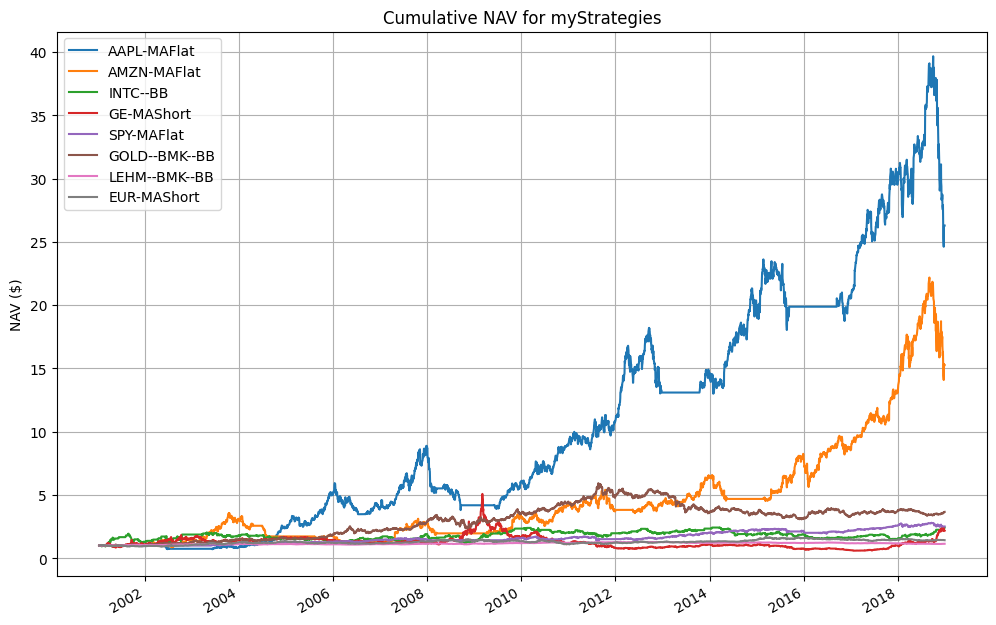

Performance Statistics:


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
AAPL-MAFlat,23.00%,28.44%,80.89%,-6071.62%
AMZN-MAFlat,21.31%,33.32%,63.95%,-4.70%
INTC--BB,8.23%,24.96%,32.97%,-37.01%
GE-MAShort,9.26%,30.86%,30.02%,-333.03%
SPY-MAFlat,6.00%,11.53%,52.01%,0.00%
GOLD--BMK--BB,9.16%,17.97%,50.95%,-50.91%
LEHM--BMK--BB,0.84%,3.74%,22.43%,-1.07%
EUR-MAShort,2.55%,10.02%,25.50%,-982.92%


Summary Performance Statistics:
                Annualized Return  Annualized Volatility  Sharpe Ratio  \
AAPL-MAFlat             0.230018               0.284368      0.808874   
AMZN-MAFlat             0.213081               0.333188      0.639521   
INTC--BB                0.082284               0.249602      0.329661   
GE-MAShort              0.092640               0.308602      0.300193   
SPY-MAFlat              0.059983               0.115322      0.520131   
GOLD--BMK--BB           0.091575               0.179729      0.509515   
LEHM--BMK--BB           0.008398               0.037444      0.224273   
EUR-MAShort             0.025544               0.100178      0.254987   

               Max Drawdown  
AAPL-MAFlat      -60.716179  
AMZN-MAFlat       -0.046958  
INTC--BB          -0.370087  
GE-MAShort        -3.330338  
SPY-MAFlat         0.000000  
GOLD--BMK--BB     -0.509129  
LEHM--BMK--BB     -0.010659  
EUR-MAShort       -9.829234  


In [27]:
cumulative_returns = (1 + joined_df_inSample).cumprod().fillna(1)

# Replacing the first NaN with the appropriate starting value
cumulative_returns.iloc[0] = 1

# Ploting the cumulative NAV using plot_and_format_y_axis
plot_and_format_y_axis(cumulative_returns, title="Cumulative NAV for myStrategies", ylabel="NAV ($)")

# Calculating and printing summary statistics, and ensure no NaN rows are passed
performance_stats = calcPerformanceStatistics(joined_df_inSample.dropna())
print("Summary Performance Statistics:\n", performance_stats)

In [28]:
def print_pct_data(df_input, fmt_spec=".4f", nan_placeholder='NaN', index_slice=None):
    # Create a lambda function for custom formatting and NaN handling
    formatter_lambda = lambda x: nan_placeholder if pd.isna(x) else f"{x * 100:{fmt_spec}}%"

    # Make a copy of the input DataFrame
    formatted_df = df_input.copy()

    # If index_slice is provided, apply formatting only to the specified rows/columns
    if index_slice is not None:
        formatted_df.loc[index_slice] = formatted_df.loc[index_slice].apply(lambda col: col.map(formatter_lambda))
    else:
        # Apply the lambda function to the entire DataFrame
        formatted_df = formatted_df.apply(lambda col: col.map(formatter_lambda))

    return formatted_df

In [29]:
# Step 3: Calculate performance statistics
joined_df_inSample_cleaned = joined_df_inSample.dropna()
performance_stats = calcPerformanceStatistics(joined_df_inSample_cleaned, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
print("Performance Statistics:\n", performance_stats)

# Interpretation of correlation and Sharpe ratios

Performance Statistics:
                Annualized Return  Annualized Volatility  Sharpe Ratio  \
AAPL-MAFlat             0.230018               0.284368      0.808874   
AMZN-MAFlat             0.213081               0.333188      0.639521   
INTC--BB                0.082284               0.249602      0.329661   
GE-MAShort              0.092640               0.308602      0.300193   
SPY-MAFlat              0.059983               0.115322      0.520131   
GOLD--BMK--BB           0.091575               0.179729      0.509515   
LEHM--BMK--BB           0.008398               0.037444      0.224273   
EUR-MAShort             0.025544               0.100178      0.254987   

               Max Drawdown  
AAPL-MAFlat      -60.716179  
AMZN-MAFlat       -0.046958  
INTC--BB          -0.370087  
GE-MAShort        -3.330338  
SPY-MAFlat         0.000000  
GOLD--BMK--BB     -0.509129  
LEHM--BMK--BB     -0.010659  
EUR-MAShort       -9.829234  


Q4. Next, you will apply the same MVO maximum-Sharpe weights that you
obtained in Part A question # 14, add a 9th column to the dataFrame which is the MVO-weighted maximum-Sharpe portfolio (just like you did in Part A question # 16). Calculate the performance statistics of this MVO maximum-Sharpe portfolio for two sub-periods: the in-sample period and then the out-of-sample period. Verify that the in-sample period Sharpe is identical to what you got in Part A question # 16. Highlight the Sharpe for the new out-of-sample period. Is it less than or greater than the Part A in-sample period Sharpe?

In [30]:
# Get the number of securities
num_securities = joined_df_inSample_cleaned.shape[1]
rng = np.random.default_rng(seed=64)

# Set up for reproducibility and define variables
num_securities = joined_df_inSample_cleaned.shape[1]  # Get the number of securities
annualization_factor = 260  # Assuming daily returns for annualization
rng = np.random.default_rng(seed=64)

# Step 1: Initialize lists to collect returns, risks, and weights
prets = []
pvols = []
weights = []  # List to store weights for each portfolio

In [31]:
# Step 2: Monte Carlo simulation for 5,000 paths
for _ in range(5000):
    # Generate random weights
    wts = rng.random(num_securities)
    wts /= np.sum(wts)  # Normalize weights

    # Step 3: Calculate portfolio return and risk
    port_return = annualization_factor * np.dot(wts, joined_df_inSample_cleaned.mean().T)
    port_risk = np.sqrt(annualization_factor) * np.sqrt(np.dot(np.dot(wts, joined_df_inSample_cleaned.cov()), wts.T))

    # Store results
    prets.append(port_return)
    pvols.append(port_risk)
    weights.append(wts)  # Store weights for this portfolio


In [32]:
# Step 4: Convert lists to numpy arrays for easy manipulation
prets = np.array(prets)
pvols = np.array(pvols)
all_weights = np.array(weights)  # Convert list of weights to a NumPy array

# Step 5: Identify the portfolios with the minimum volatility and maximum Sharpe ratio
min_vol_index = np.argmin(pvols)  # Minimum volatility portfolio
max_sharpe_index = np.argmax(prets / pvols)  # Maximum Sharpe ratio portfolio

# Step 6: Extract the weight vectors for the minimum volatility and maximum Sharpe ratio portfolios
min_vol_weights = all_weights[min_vol_index]
max_sharpe_weights = all_weights[max_sharpe_index]

# Step 7: Pretty-print the weights side-by-side in a DataFrame
weight_df_inSample = pd.DataFrame({
    'Min Vol': min_vol_weights,
    'Max Sharpe': max_sharpe_weights
}, index=joined_df_inSample_cleaned.columns)

print("Weights for Min Volatility and Max Sharpe Ratio Portfolios:")
print(weight_df_inSample)

Weights for Min Volatility and Max Sharpe Ratio Portfolios:
                Min Vol  Max Sharpe
AAPL-MAFlat    0.041172    0.206298
AMZN-MAFlat    0.015565    0.121295
INTC--BB       0.107019    0.092427
GE-MAShort     0.032977    0.077171
SPY-MAFlat     0.173901    0.007155
GOLD--BMK--BB  0.081849    0.226644
LEHM--BMK--BB  0.320839    0.130736
EUR-MAShort    0.226677    0.138275


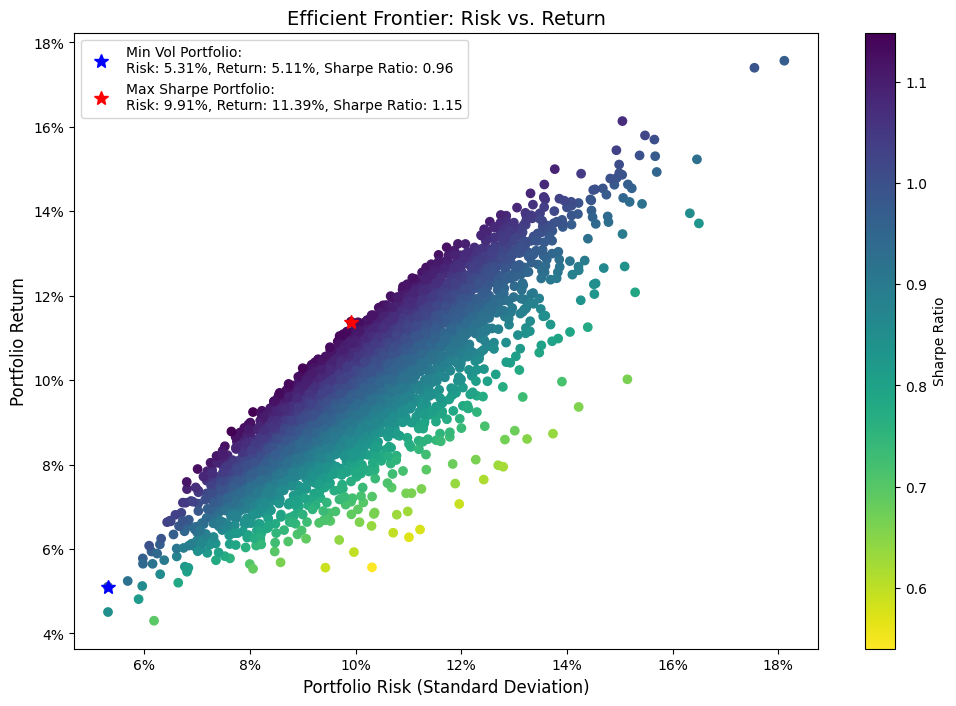

In [33]:
# Plot the return vs. risk for the portfolio combinations
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick # for the last few efficient frontier plots

plt.figure(figsize=(12, 8))
sc = plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='viridis_r')  # Use a colormap based on the Sharpe ratio

# Highlight Min Volatility and Max Sharpe Ratio portfolios
min_vol_index = np.argmin(pvols)
max_sharpe_index = np.argmax(prets / pvols)

# Plot the points for Min Vol and Max Sharpe with appropriate markers
min_vol_marker, = plt.plot(pvols[min_vol_index], prets[min_vol_index], 'b*', markersize=10, label='Min Vol Portfolio')
max_sharpe_marker, = plt.plot(pvols[max_sharpe_index], prets[max_sharpe_index], 'r*', markersize=10, label='Max Sharpe Portfolio')

# Calculate the Sharpe ratios for both portfolios
min_vol_sharpe = prets[min_vol_index] / pvols[min_vol_index]
max_sharpe_value = prets[max_sharpe_index] / pvols[max_sharpe_index]

# Construct the legend text with details
min_vol_text = f'Min Vol Portfolio:\nRisk: {pvols[min_vol_index]:.2%}, Return: {prets[min_vol_index]:.2%}, Sharpe Ratio: {min_vol_sharpe:.2f}'
max_sharpe_text = f'Max Sharpe Portfolio:\nRisk: {pvols[max_sharpe_index]:.2%}, Return: {prets[max_sharpe_index]:.2%}, Sharpe Ratio: {max_sharpe_value:.2f}'

# Add the legend with the correct markers and custom text
plt.legend([min_vol_marker, max_sharpe_marker], [min_vol_text, max_sharpe_text], loc='best')

plt.xlabel('Portfolio Risk (Standard Deviation)', fontsize=12)
plt.ylabel('Portfolio Return', fontsize=12)
plt.title('Efficient Frontier: Risk vs. Return', fontsize=14)

# Format axes as percentages
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

# Add colorbar for Sharpe Ratio
cbar = plt.colorbar(sc)
cbar.set_label('Sharpe Ratio')

plt.show()

In [34]:
# Calculate max sharpe portfolio returns
max_sharpe_portfolio_returns_inSample = np.dot(joined_df_inSample_cleaned, max_sharpe_weights)

# Step 2: Convert to DataFrame, and ensure it has the Date index from 'top_logReturns'
max_sharpe_portfolio_df_inSample = pd.DataFrame(max_sharpe_portfolio_returns_inSample, columns=["Max Sharpe Portfolio"], index=joined_df_inSample_cleaned.index)

# Display the updated DataFrame with the new column
my_strategies_inSample = pd.merge(myStrategies_inSample, max_sharpe_portfolio_df_inSample, left_index=True, right_index=True)
my_strategies_inSample.head()



,AAPL-MAFlat,AMZN-MAFlat,EUR-MAShort,GE-MAShort,GOLD--BMK--BB,INTC--BB,LEHM--BMK--BB,SPY-MAFlat,Max Sharpe Portfolio
2001-01-12,-0.0,0.0,0.000631,0.018971,0.000189,-0.0,-0.004724,-0.0,0.000976
2001-01-16,-0.0,0.0,0.009081,-0.036270,-0.002842,-0.0,0.001185,0.0,-0.002032
2001-01-17,-0.0,0.0,0.007346,0.014618,0.000000,-0.0,0.003317,0.0,0.002578
2001-01-18,0.0,0.0,-0.007665,-0.019881,0.003787,0.0,0.004006,0.0,-0.001212
2001-01-19,0.0,0.0,0.009376,0.013210,0.000756,0.0,-0.003085,-0.0,0.002084


In [35]:
# Function to print percentage data format
def print_pct_data(data_frame, format_spec="{:.4%}", na_rep="NaN", index_slice=None):
    if index_slice is not None:
        # Apply formatting to the specified subset
        return data_frame.style.format(format_spec, na_rep=na_rep, subset=pd.IndexSlice[:,index_slice])
    else:
        # Apply formatting to the entire DataFrame
        return data_frame.style.format(format_spec, na_rep=na_rep)

In [36]:
calcPerformanceStatistics(my_strategies_inSample, annualization_factor=260, print_screen=True, percent_format_string="{:.2%}")

Performance Statistics:


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
AAPL-MAFlat,23.00%,28.44%,80.89%,-6071.62%
AMZN-MAFlat,21.31%,33.32%,63.95%,-4.70%
EUR-MAShort,2.55%,10.02%,25.50%,-982.92%
GE-MAShort,9.26%,30.86%,30.02%,-333.03%
GOLD--BMK--BB,9.16%,17.97%,50.95%,-50.91%
INTC--BB,8.23%,24.96%,32.97%,-37.01%
LEHM--BMK--BB,0.84%,3.74%,22.43%,-1.07%
SPY-MAFlat,6.00%,11.53%,52.01%,0.00%
Max Sharpe Portfolio,11.39%,9.91%,114.86%,-3.99%


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
AAPL-MAFlat,0.230018,0.284368,0.808874,-60.716179
AMZN-MAFlat,0.213081,0.333188,0.639521,-0.046958
EUR-MAShort,0.025544,0.100178,0.254987,-9.829234
GE-MAShort,0.092640,0.308602,0.300193,-3.330338
GOLD--BMK--BB,0.091575,0.179729,0.509515,-0.509129
INTC--BB,0.082284,0.249602,0.329661,-0.370087
LEHM--BMK--BB,0.008398,0.037444,0.224273,-0.010659
SPY-MAFlat,0.059983,0.115322,0.520131,0.000000
Max Sharpe Portfolio,0.113866,0.099135,1.148594,-0.039855


In [37]:
myStrategies_outOfSample

,AAPL-MAFlat,AMZN-MAFlat,EUR-MAShort,GE-MAShort,GOLD--BMK--BB,INTC--BB,LEHM--BMK--BB,SPY-MAFlat
2019-01-02,0.0,0.0,0.010784,-0.061479,0.001636,0.003191,0.001133,0.0
2019-01-03,-0.0,-0.0,-0.004398,-0.001241,0.007515,-0.000000,0.005373,-0.0
2019-01-04,0.0,0.0,-0.000088,-0.020872,-0.006379,0.000000,-0.004796,0.0
2019-01-07,-0.0,0.0,-0.006909,-0.060124,0.002454,0.000000,-0.000424,0.0
2019-01-08,0.0,0.0,0.002880,0.020810,-0.002967,0.000000,-0.001391,0.0
...,...,...,...,...,...,...,...,...
2022-10-25,0.0,0.0,-0.009274,0.004919,0.002053,0.000000,0.009420,0.0
2022-10-26,-0.0,-0.0,-0.011473,-0.033143,0.006872,-0.000000,0.004812,-0.0
2022-10-27,-0.0,-0.0,0.011674,-0.007131,-0.000757,-0.000000,0.005143,-0.0
2022-10-28,0.0,-0.0,-0.000100,-0.030197,-0.011154,0.000000,-0.002526,0.0


In [38]:
aapl_os = myStrategies_outOfSample[['AAPL-MAFlat']]
amzn_os = myStrategies_outOfSample[['AMZN-MAFlat']]
intc_os = myStrategies_outOfSample[['INTC--BB']]
ge_os = myStrategies_outOfSample[['GE-MAShort']]
spy_os = myStrategies_outOfSample[['SPY-MAFlat']]
gold_os = myStrategies_outOfSample[['GOLD--BMK--BB']]
lehm_os = myStrategies_outOfSample[['LEHM--BMK--BB']]
eur_os = myStrategies_outOfSample[['EUR-MAShort']]

In [39]:
# Start with the first DataFrame
joined_df_outOfSample = aapl_os

# List of remaining DataFrames to merge
dfs_to_merge = [amzn_os, intc_os, ge_os, spy_os, gold_os, lehm_os, eur_os]

# Perform inner join (merge) sequentially on each DataFrame
for df in dfs_to_merge:
    joined_df_outOfSample = joined_df_outOfSample.merge(df, left_index=True, right_index=True, how='inner')

# Display the joined DataFrame
joined_df_outOfSample


,AAPL-MAFlat,AMZN-MAFlat,INTC--BB,GE-MAShort,SPY-MAFlat,GOLD--BMK--BB,LEHM--BMK--BB,EUR-MAShort
2019-01-02,0.0,0.0,0.003191,-0.061479,0.0,0.001636,0.001133,0.010784
2019-01-03,-0.0,-0.0,-0.000000,-0.001241,-0.0,0.007515,0.005373,-0.004398
2019-01-04,0.0,0.0,0.000000,-0.020872,0.0,-0.006379,-0.004796,-0.000088
2019-01-07,-0.0,0.0,0.000000,-0.060124,0.0,0.002454,-0.000424,-0.006909
2019-01-08,0.0,0.0,0.000000,0.020810,0.0,-0.002967,-0.001391,0.002880
...,...,...,...,...,...,...,...,...
2022-10-25,0.0,0.0,0.000000,0.004919,0.0,0.002053,0.009420,-0.009274
2022-10-26,-0.0,-0.0,-0.000000,-0.033143,-0.0,0.006872,0.004812,-0.011473
2022-10-27,-0.0,-0.0,-0.000000,-0.007131,-0.0,-0.000757,0.005143,0.011674
2022-10-28,0.0,-0.0,0.000000,-0.030197,0.0,-0.011154,-0.002526,-0.000100


In [40]:
# Calculate the daily returns of the Max Sharpe portfolio
joined_df_outOfSample_cleaned = joined_df_outOfSample.dropna()
max_sharpe_portfolio_returns_outOfSample = np.dot(joined_df_outOfSample_cleaned, max_sharpe_weights)

# Add the maximum Sharpe portfolio returns to the DataFrame
joined_df_outOfSample_cleaned['Max-Sharpe'] = max_sharpe_portfolio_returns_outOfSample

In [48]:
calcPerformanceStatistics(joined_df_outOfSample_cleaned, annualization_factor=260, print_screen=True, percent_format_string="{:.2%}")

Performance Statistics:


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
AAPL-MAFlat,24.16%,32.57%,74.19%,-209.71%
AMZN-MAFlat,9.51%,25.60%,37.16%,-495.75%
INTC--BB,13.01%,32.60%,39.90%,-8318.42%
GE-MAShort,-49.64%,45.89%,-108.18%,-134113.72%
SPY-MAFlat,6.83%,18.81%,36.33%,-1015.95%
GOLD--BMK--BB,6.56%,15.40%,42.61%,-5.53%
LEHM--BMK--BB,-4.51%,5.05%,-89.31%,-1524.47%
EUR-MAShort,7.02%,7.29%,96.22%,-0.98%
Max-Sharpe,5.43%,12.43%,43.65%,-253.47%


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
AAPL-MAFlat,0.241633,0.325673,0.741950,-2.097066
AMZN-MAFlat,0.095124,0.255954,0.371644,-4.957523
INTC--BB,0.130082,0.326006,0.399018,-83.184235
GE-MAShort,-0.496444,0.458925,-1.081755,-1341.137154
SPY-MAFlat,0.068338,0.188126,0.363255,-10.159496
GOLD--BMK--BB,0.065599,0.153952,0.426097,-0.055291
LEHM--BMK--BB,-0.045111,0.050512,-0.893086,-15.244712
EUR-MAShort,0.070191,0.072949,0.962195,-0.009828
Max-Sharpe,0.054263,0.124312,0.436508,-2.534698


Q5. Benchmarks: Next, we will compare your active portfolio’s out-of-sample Sharpe with that of a simple (passive) equal-weighted portfolio of just the benchmarks (“-BMK-MA”) (i.e., no technical strategies applied) for the same out-of-sample period.
Construct an equal-weighted portfolio of the benchmark versions of your chosen instruments like you did in Part A question # 18(a) and calculate its summary statistics for the out-of-sample period. This is your “passive” portfolio. Highlight the passive benchmark-only Sharpe ratio for the new out-of-sample period.


In [51]:
# Step 1: Define the BMK columns (replace these with the actual BMK column names from your master DataFrame)
bmk_columns = ['AAPL-BMK-MA', 'AMZN-BMK-MA', 'INTC-BMK-MA', 'GE-BMK-MA', 'SPY-BMK-MA', 'GOLD-BMK-MA', 'LEHM-BMK-MA', 'EUR-BMK-MA']

# Step 2: Extract only the BMK columns from the master DataFrame
df_bmk_only = master_strategies_df.loc['2019-01-02':'2022-10-31', :][bmk_columns].dropna()

# Step 3: Apply equal weights to each BMK column (1/8 for each column, assuming 8 columns)
equal_weight = 1 / len(bmk_columns)
df_bmk_equal_weighted = df_bmk_only * equal_weight

# Display the resulting DataFrame
df_bmk_equal_weighted


,AAPL-BMK-MA,AMZN-BMK-MA,INTC-BMK-MA,GE-BMK-MA,SPY-BMK-MA,GOLD-BMK-MA,LEHM-BMK-MA,EUR-BMK-MA
2019-01-02,0.000143,0.003055,0.000399,0.007685,0.000130,0.000205,0.000142,-0.001348
2019-01-03,-0.013116,-0.003196,-0.007073,0.000155,-0.003019,0.000939,0.000672,0.000550
2019-01-04,0.005225,0.006106,0.007444,0.002609,0.004118,-0.000797,-0.000600,0.000011
2019-01-07,-0.000279,0.004222,0.000581,0.007516,0.000982,0.000307,-0.000053,0.000864
2019-01-08,0.002360,0.002059,0.000788,-0.002601,0.001169,-0.000371,-0.000174,-0.000360
...,...,...,...,...,...,...,...,...
2022-10-25,0.002394,0.000811,0.001053,-0.000615,0.001980,0.000257,0.001178,0.001159
2022-10-26,-0.002478,-0.005228,-0.000915,0.004143,-0.000945,0.000859,0.000601,0.001434
2022-10-27,-0.003867,-0.005186,-0.004395,0.000891,-0.000669,-0.000095,0.000643,-0.001459
2022-10-28,0.009104,-0.008809,0.012660,0.003775,0.002939,-0.001394,-0.000316,0.000013


In [52]:
calcPerformanceStatistics(df_bmk_equal_weighted, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
AAPL-BMK-MA,0.046022,0.043635,1.054715,-0.074316
AMZN-BMK-MA,0.010522,0.044739,0.235184,-0.000141
INTC-BMK-MA,-0.016986,0.050013,-0.339627,-4.697327
GE-BMK-MA,0.009823,0.057491,0.170861,-1.661276
SPY-BMK-MA,0.014750,0.028878,0.510779,-0.043888
GOLD-BMK-MA,0.008200,0.019244,0.426097,-0.006911
LEHM-BMK-MA,-0.005639,0.006314,-0.893086,-1.905589
EUR-BMK-MA,-0.005041,0.009129,-0.552204,-2.237639


In [53]:
import numpy as np

# Step 1: Calculate the daily returns of the equal-weighted BMK portfolio
# Sum the weighted BMK columns to get the portfolio's daily return series
equal_weighted_portfolio_returns_bmk = df_bmk_equal_weighted.sum(axis=1)

# Step 2: Calculate the annualized Sharpe Ratio
# Assuming daily returns and using 252 trading days for annualization
mean_daily_return = equal_weighted_portfolio_returns_bmk.mean()
std_dev_daily_return = equal_weighted_portfolio_returns_bmk.std()
sharpe_ratio = (mean_daily_return / std_dev_daily_return) * np.sqrt(260)

print("Sharpe Ratio of BMK-only equal-weighted portfolio in the outOfSample is:", sharpe_ratio)


Sharpe Ratio of BMK-only equal-weighted portfolio in the outOfSample is: 0.3424211731372689


Q6. Comment on how your active portfolio (for which you will charge 2-&-20) (a) performs out-of-sample and (b) whether it outperforms a simple (passive) equally-weighted benchmark portfolio of your chosen instruments for the out-of-sample period. If it does, what does that say about your chosen active portfolio in Part A? If it doesn’t, then was this whole exercise a waste of time? Or are there any lessons to be learned?

Ans: a) For the out-of-sample period (2018-2022), the performance of my active portfolio shows mixed results. The **annualized return** for the max-Sharpe portfolio decreased to 0.054263, compared to 0.089111 during the in-sample period (1999–2018). Additionally, the **Sharpe ratio** also dropped significantly, from **1.148594** to **0.436508**, indicating that the portfolio was less effective in balancing return relative to risk in the out-of-sample period.

b) The active portfolio from Project B (out-of-sample) with a Sharpe ratio of 0.4365 does **outperform** the equally weighted benchmark portfolio, which has a Sharpe ratio of 0.3424 for the same period.

Further, The active portfolio constructed in Project A, with a Sharpe ratio of 1.11, was highly optimized for the in-sample period (1999 to 2018). Although its Sharpe ratio dropped significantly in the out-of-sample period (ProjectB), it still managed to outperform the benchmark portfolio. This suggests that the active strategies, despite the lower performance, still offered value through active management, indicating that the portfolio from Part A was not overfitted to the point of being irrelevant in new market conditions.


***Lessons Learned:***

*Active Management Adds Value:* The fact that the active portfolio outperformed the benchmark in the out-of-sample period demonstrates that active management, even when less effective than in-sample, can still offer superior risk-adjusted returns over a passive strategy.
Overfitting Concerns: The substantial drop in Sharpe ratio (from 1.11 to 0.437) suggests that the active portfolio was over-optimized for the in-sample data. This underlines the risk of overfitting when relying too heavily on historical data to make future predictions.

*Adaptability:* The performance gap between in-sample and out-of-sample results indicates that market conditions from 2018 to 2022 were different, and the strategies that worked previously were less effective during this time. This highlights the need for strategies that can adapt to different market cycles and volatility patterns.

*Balance Between Strategies:* The portfolio's ability to outperform the benchmark despite some underperforming components shows that diversification across different instruments and strategies can still produce a more resilient overall portfolio, even when individual components may falter.









We pledge on our honor that we have not given nor received any unauthorized assistance on this
assignment to/from other groups. Nor have we received any assistance from prior year students." (We have accidently missed to include this honor pledge in projectA's notebook but we have adhered it to the best of our abilities.)

- Aniket Chafekar, Rutwik Patil, Saurabh Shinde, Shivam Sharma.